# probabilistic Neural network for PhotoZ

- last update 2023-05-02 


### AlxndrMlk

- you tube : https://www.youtube.com/watch?v=KJxmC5GCWe4

- github : https://github.com/AlxndrMlk/PyDataGlobal2021


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')

tfd = tfp.distributions
tfpl = tfp.layers

2023-05-07 14:48:47.667126: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys
import h5py
import copy

In [3]:
def get_stats(z_spec,z_phot,slope=0.15):
    """
    input : 
       - z_spec : spectroscopic redshift or true redshift
       - z_phot : photo-z reedshift
       - slope : slope of line defining the outliers  3 x sigma_z with sigma_z = 5%, so slope = 3 x 0.05 = 0.15 
    """
    
    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > slope
    notmask = ~mask 
    
    # Standard Deviation of the predicted redshifts compared to the data:
    #-----------------------------------------------------------------
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)
    print('Standard Deviation: %6.4f' % std_result)
    

    # Normalized MAD (Median Absolute Deviation):
    #------------------------------------------
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))
    print('Normalized MAD: %6.4f' % nmad)

    # Percentage of delta-z > 0.15(1+z) outliers:
    #-------------------------------------------
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    print('Delta z >0.15(1+z) outliers: %6.3f percent' % (100.*eta))
    
    # Median offset (normalized by (1+z); i.e., bias:
    #-----------------------------------------------
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    print('Median offset: %6.3f +/- %6.3f' % (bias,sigbias))
    
    
     # overlay statistics with titles left-aligned and numbers right-aligned
    stats_txt = '\n'.join([
        'NMAD  = {:0.2f}'.format(nmad),
        'STDEV = {:0.2f}'.format(std_result),
        'BIAS  = {:0.2f}'.format(bias),
        'ETA   = {:0.2f}'.format(eta)
    ])
    
    
    return nmad,std_result,bias,eta,stats_txt

In [4]:
def getdataerror(hf):
    key_sel = list(hf.keys())[0]
    group = hf.get(key_sel)
    
    mag_err_u_lsst = np.array(group.get("mag_err_u_lsst"))
    mag_err_g_lsst = np.array(group.get("mag_err_g_lsst"))
    mag_err_r_lsst = np.array(group.get("mag_err_r_lsst"))
    mag_err_i_lsst = np.array(group.get("mag_err_i_lsst"))
    mag_err_z_lsst = np.array(group.get("mag_err_z_lsst"))
    mag_err_y_lsst = np.array(group.get("mag_err_y_lsst"))
    mag_u_lsst =  np.array(group.get("mag_u_lsst"))
    mag_g_lsst =  np.array(group.get("mag_g_lsst"))
    mag_r_lsst =  np.array(group.get("mag_r_lsst"))
    mag_i_lsst =  np.array(group.get("mag_i_lsst"))
    mag_z_lsst =  np.array(group.get("mag_z_lsst"))
    mag_y_lsst =  np.array(group.get("mag_y_lsst"))
    redshift = np.array(group.get("redshift"))
    
    data = np.vstack((
                    mag_u_lsst, 
                    mag_g_lsst, 
                    mag_r_lsst, 
                    mag_i_lsst, 
                    mag_z_lsst,
                    mag_y_lsst,
                    mag_err_u_lsst, 
                    mag_err_g_lsst, 
                    mag_err_r_lsst, 
                    mag_err_i_lsst, 
                    mag_err_z_lsst,
                    mag_err_y_lsst,
                    redshift)) 
    data = data.T
    indexes_bad = np.where(data[:,0]>40)[0]
    datacut = np.delete(data,indexes_bad,axis=0)
    features = datacut[:,0:6]
    errors = datacut[:,6:-1]
    targets = datacut[:,-1]
    return features,errors,targets    

https://www.youtube.com/watch?v=KJxmC5GCWe4

## Configuration

TFP docs are [here](https://www.tensorflow.org/probability/api_docs/python/tfp)

## Input data

In [5]:
input_train_file_h5 = "../data/test_dc2_training_9816.hdf5"
input_test_file_h5 = "../data/test_dc2_validation_9816.hdf5"

In [6]:
hftrain =  h5py.File(input_train_file_h5, 'r') 
hftest =  h5py.File(input_test_file_h5, 'r') 

In [7]:
# swap train and test because more example in validation
x_train0,x_train_error0,y_train = getdataerror(hftest)
x_test0,x_test_error0,y_test = getdataerror(hftrain)

#x_train0,x_train_error0,y_train = getdataerror(hftrain)
#x_test0,x_test_error0,y_test = getdataerror(hftest)

In [8]:
NBANDS = x_train0.shape[1]
NSAMPLES = x_train0.shape[0]
NSIM= 1

## Simulation

In [9]:
def simulatesamples(x,ex,nsim=NSIM):
    nsamples = x.shape[0]
    nbands = x.shape[1]
    
    all_samples = np.zeros((nsamples,nbands,nsim))
    for idx in range(nbands):
        mean = x[:,idx]
        sig = ex[:,idx]
        simdata = np.random.normal(mean, sig, (nsim,nsamples))
        all_samples[:,idx,: ] = simdata.T
    return all_samples  

In [10]:
train_data = simulatesamples(x_train0,x_train_error0,NSIM)
test_data = simulatesamples(x_test0,x_test_error0,NSIM)

In [11]:
def plot_histo_data(the_data,nbands=6,xmin=18,xmax=30):
    
    the_cols = ["b","g","r","y","grey","m"]
    fig, axes = plt.subplots(ncols=3,nrows=2,figsize=(12,4))

    for idx, ax in enumerate(axes.flat):
        ax.hist(the_data[:,idx],bins=100,range=(xmin,xmax),facecolor=the_cols[idx])
    
    plt.show()
    
    

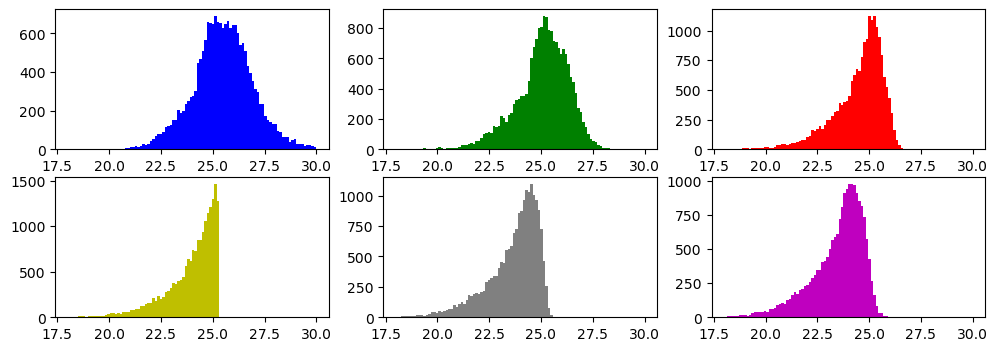

In [12]:
plot_histo_data(x_train0) 

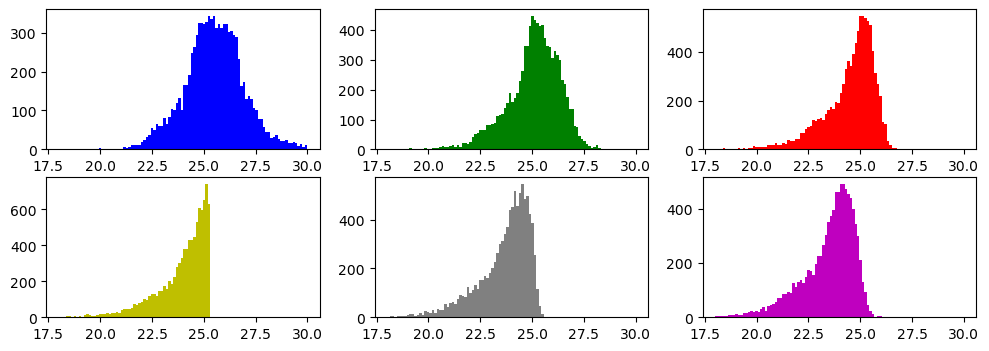

In [13]:
plot_histo_data(x_test0) 

### Data preparation  : normalisation

In [14]:
mean = np.mean(train_data[:,:,0],axis=0)
std  = np.std(train_data[:,:,0],axis=0)

In [15]:
x_train0 = train_data[:,:,0]
x_test0 = test_data[:,:,0]

In [16]:
x_train0_norm = (x_train0-mean)/std
x_test0_norm = (x_test0-mean)/std

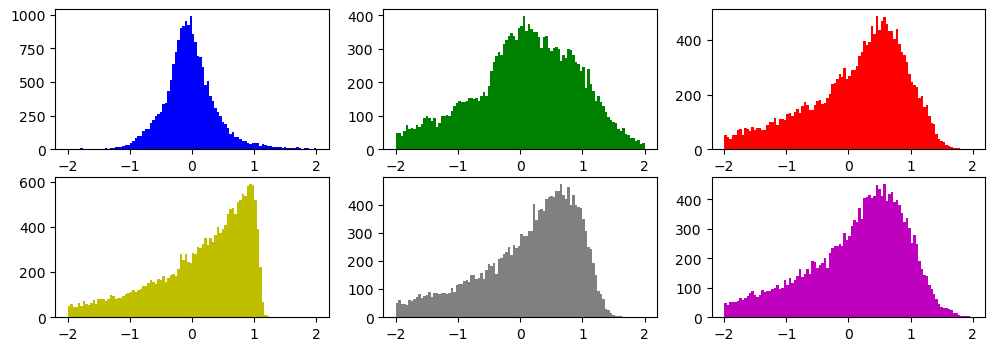

In [17]:
plot_histo_data(x_train0_norm,xmin=-2,xmax=2) 

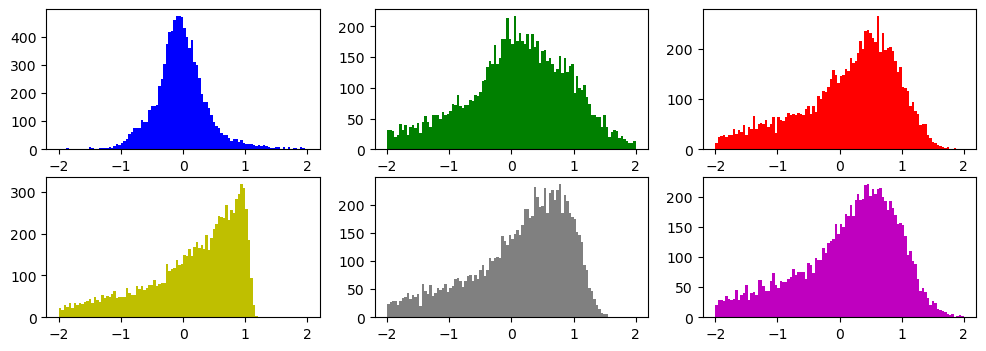

In [18]:
plot_histo_data(x_test0_norm,xmin=-2,xmax=2) 

In [19]:
all_x_train_norm = []
all_x_test_norm = []
for isim in range(NSIM):
    x_train_norm = (train_data[:,:,isim] - mean)/std
    x_test_norm = (test_data[:,:,isim] - mean)/std
    all_x_train_norm.append(x_train_norm) 
    all_x_test_norm.append(x_test_norm) 

In [20]:
x_train = copy.deepcopy(all_x_train_norm[0])
x_test = copy.deepcopy(all_x_test_norm[0])
y_train = copy.deepcopy(y_train[:,np.newaxis])
y_test = copy.deepcopy(y_test[:,np.newaxis])

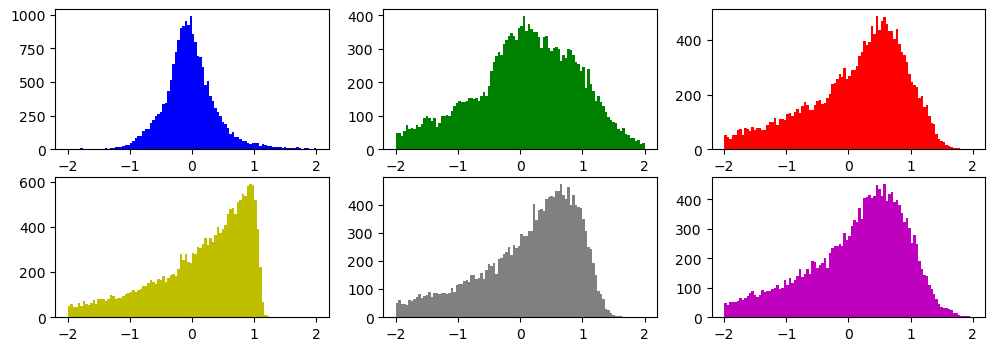

In [21]:
plot_histo_data(x_train,xmin=-2,xmax=2) 

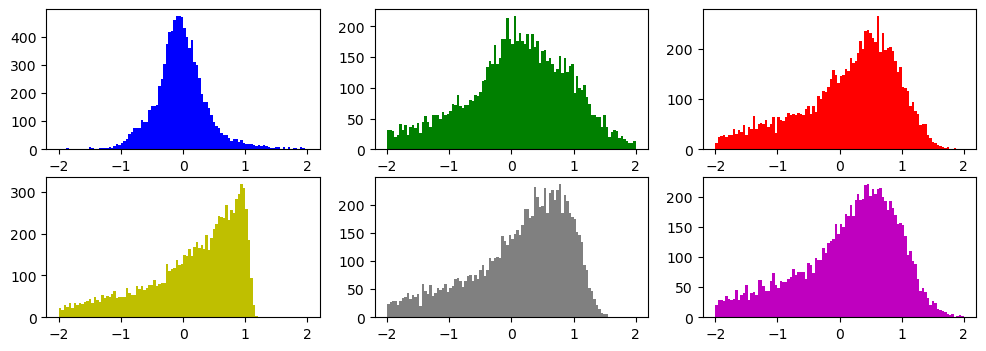

In [22]:
plot_histo_data(x_test,xmin=-2,xmax=2) 

##  Inference

####  Standard NN model

In [23]:
# Let's build a simple linear regression model
model_simple = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(6,))
])

# Compile 
model_simple.compile(loss='mse', optimizer='sgd')

# Fit
history = model_simple.fit(x_train, y_train, epochs=500, verbose=0)

In [24]:
[print(np.squeeze(w.numpy())) for w in model_simple.weights];

[-0.0071499  -0.6979717   0.65866804  0.45063722  0.14153333 -0.5213347 ]
0.9338929


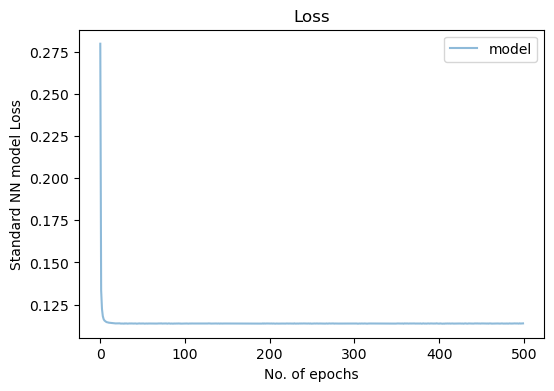

In [25]:
# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='model', alpha=.5)
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Standard NN model Loss')
plt.legend()
plt.show()

In [26]:
# Predict
y_pred_test = model_simple(x_test)
y_pred_train = model_simple(x_train)

In [27]:
y_pred_test

<tf.Tensor: shape=(9511, 1), dtype=float32, numpy=
array([[0.5179512 ],
       [0.80698615],
       [0.58412665],
       ...,
       [0.91106266],
       [1.0329413 ],
       [0.8225124 ]], dtype=float32)>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


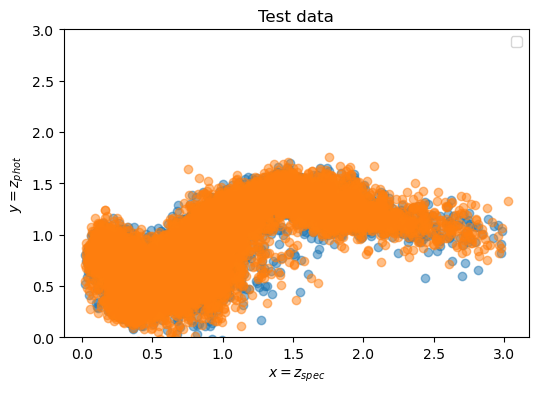

In [28]:
# Plot the data and a trained regression line
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred_test, alpha=.5)
plt.scatter(y_train, y_pred_train, alpha=.5)
plt.xlabel('$x = z_{spec}$')
plt.ylabel('$y = z_{phot}$')
plt.title('Test data')
plt.legend()
plt.ylim(0,3)
plt.show()

### Tuto on probabilistic

https://towardsdatascience.com/introduction-to-tensorflow-probability-6d5871586c0e



        tfpl = tfp.layersmodel = tf.keras.Sequential([
        tfkl.Dense(2, input_shape = (1,)),
        tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3+tf.math.abs(t[...,1:])))
         ])

### Model with probabilistic output - aleatoric uncertainty (learn mean & std)

In [29]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_modelaleatoric.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

In [30]:
# Let's build a model with probabilistic output (mean & std) - a simple way
event_shape = 1

model_aleatoric = tf.keras.Sequential([
    tf.keras.layers.Dense(2, input_shape=(6,)),
    tfpl.IndependentNormal(event_shape=event_shape)
])

# Define neg. loglik. loss function
def neg_loglik(y_true, y_pred):
    return -y_pred.log_prob(y_true)

# Compile 
model_aleatoric.compile(loss=neg_loglik, optimizer='sgd')

# Fit
history = model_aleatoric.fit(x_train, y_train, epochs = 100, verbose=1, validation_data = (x_test, y_test),  callbacks = [earlystopping_callback, savemodel_callback] )

Epoch 1/100
593/593 [==============================] - 3s 4ms/step - loss: nan - val_loss: nan
Epoch 2/100
593/593 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 3/100
593/593 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 4/100
593/593 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 5/100
593/593 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 6/100
593/593 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 7/100
593/593 [==============================] - 2s 3ms/step - loss: nan - val_loss: nan
Epoch 8/100
593/593 [==============================] - 2s 3ms/step - loss: nan - val_loss: nan
Epoch 9/100
593/593 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan
Epoch 10/100
593/593 [==============================] - 1s 2ms/step - loss: nan - val_loss: nan


In [31]:
[print(np.squeeze(w.numpy())) for w in model_aleatoric.weights];

[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
[nan nan]


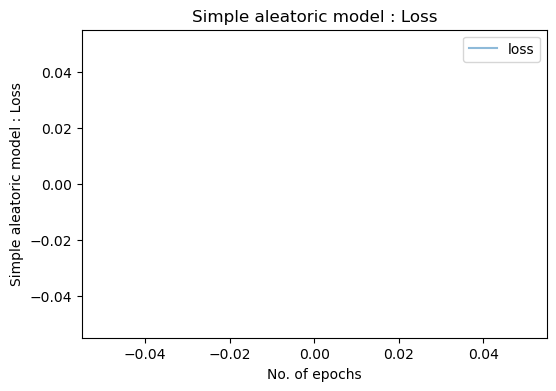

In [32]:
# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='loss', alpha=.5)
plt.title('Simple aleatoric model : Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Simple aleatoric model : Loss')
plt.legend()
plt.show()

In [33]:
# Let's compare distributions - y_train & y_model
y_model_test = model_aleatoric(x_test).sample().numpy()
y_model_train = model_aleatoric(x_train).sample().numpy()

In [34]:
y_model_test

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

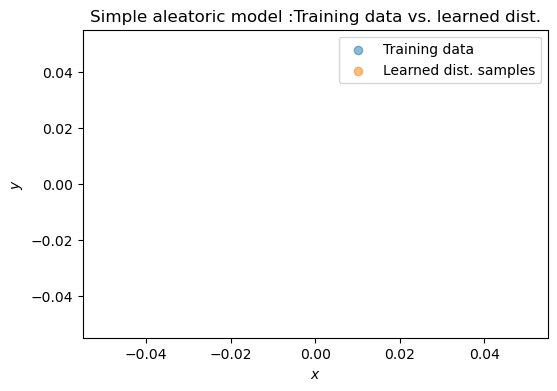

In [35]:
# Plot 
plt.figure(figsize=(6, 4))
plt.scatter(y_train, y_model_train, alpha=.5, label='Training data')
plt.scatter(y_test, y_model_test, alpha=.5, label='Learned dist. samples')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.title('Simple aleatoric model :Training data vs. learned dist.')
plt.show()

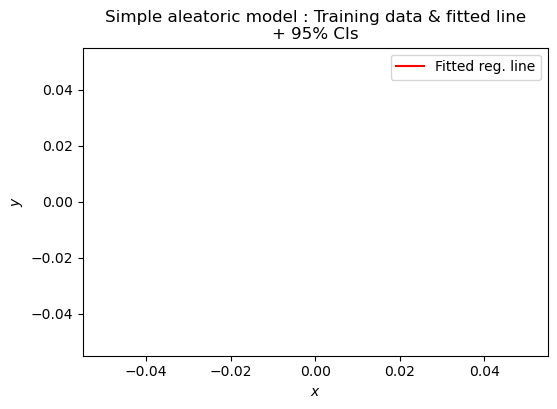

In [36]:
# Compute conf ints
y_sample = model_aleatoric(x_train).sample()
y_hat = model_aleatoric(x_train).mean()
y_sd = model_aleatoric(x_train).stddev()
y_hat_lower = y_hat - 2 * y_sd
y_hat_upper = y_hat + 2 * y_sd

# Plot conf ints
plt.figure(figsize=(6, 4))
plt.scatter(y_train, y_sample, alpha=.5)
plt.plot(y_train, y_hat, label='Fitted reg. line', c='r')
#plt.fill_between(np.squeeze(x_train), np.squeeze(y_hat_lower), np.squeeze(y_hat_upper), alpha=.1, label='$+/- 2SD$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Simple aleatoric model : Training data & fitted line\n+ 95% CIs')
plt.legend()
plt.show()

## 3. Modeling epistemic uncertainty - `tfpl.DenseVariational`

Now, we're going to model weight's uncertainty. 

This means, that each weight in our network will now be represented by a **distribution**, and **not** just a **point estimate**.

<br><br>

<img src="https://sanjaykthakur.files.wordpress.com/2018/12/bayes_nn.png">
<p style="text-align: center"><sup>Image from <a href="https://sanjaykthakur.com/2018/12/05/the-very-basics-of-bayesian-neural-networks/">https://sanjaykthakur.com/2018/12/05/the-very-basics-of-bayesian-neural-networks/</a></sup></p>

<br><br>

To do this we'll use **Bayes by Backprop** method introduced in a Blundell et al. paper [Weight uncertainty in neural networks](https://arxiv.org/pdf/1505.05424.pdf) (2015).

<br>

We'll try to estimate weight distribution parameters $\theta$, given data $D$:


$$\large P(\theta | D) = \frac{P(D | \theta) P(\theta)}{P(D)} $$


We'll follow a three-step formula to achieve this:

1. Pick a prior density over weights $P(\theta)$
2. Use training data $D$ to determine the likelihood $P(D | \theta)$
3. Estimate the posterior density over weights $P(\theta | D)$ 

<br>

Keywords: [***KL divergence***](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), [***ELBO***](https://en.wikipedia.org/wiki/Evidence_lower_bound), [***reparametrization trick***](https://arxiv.org/pdf/1505.05424.pdf)

### 3.1 Epistemic uncertainty - linear case

In [37]:
# Let's start with our linear data!
x_train_100 = x_train[:100,:]
x_train_1000 = x_train[:1000,:]

y_train_100 = y_train[:100,:]
y_train_1000 = y_train[:1000,:]

y_train_100 = y_train[:100,:]
y_train_1000 = y_train[:1000,:]

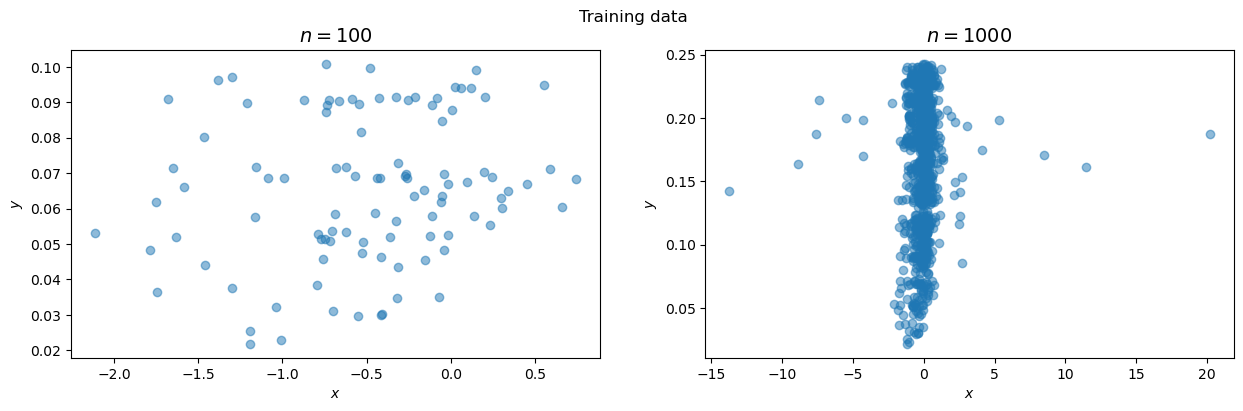

In [38]:
# Plot the data
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.scatter(x_train_100[:,0], y_train_100[:,0], alpha=.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$n=100$', fontsize=14)

plt.subplot(122)
plt.scatter(x_train_1000[:,0], y_train_1000[:,0], alpha=.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$n=1000$', fontsize=14)

plt.suptitle('Training data')
plt.show()

#### 3.1.1 Define prior and posterior

`prior()` and `posterior()` functions are necessary to parametrize `tfpl.DenseVariational` layer.

They both need to take `kernel_size`, `bias_size` and `dtype` arguments.

In [39]:
# Prior - diagonal MVN ~ N(0, 1)
def prior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    prior_model = tf.keras.Sequential([
        
        tfpl.DistributionLambda(
            # Non-trianable distribution
            lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    
    return prior_model


# Posterior
def posterior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    posterior_model = tf.keras.Sequential([
        
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    
    return posterior_model

#### 3.1.2 Aleatoric uncertainty - define a model with `DenseVariational` layer

In [40]:
# Define the model
def get_aleatoric_model(x_train_shape):
    
    model = tf.keras.Sequential([
        tfpl.DenseVariational(
            1,
            input_shape=(6,),
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1/x_train_shape, # Normalizing to scale the D_KL term in ELBO properly when using minibatches.
            kl_use_exact=False) # could be `True` in this case, but we go for estimated value
    ])

    # Compile
    model.compile(loss='mse', optimizer='sgd')
    
    return model


In [41]:
# Fit the model on two datasets 
print('Fitting `model_100`...')
model_100 = get_aleatoric_model(100)
history_100 = model_100.fit(x_train_100, y_train_100, epochs=1000, verbose=False)

print('Fitting `model_1000`...')
model_1000 = get_aleatoric_model(1000)
history_1000 = model_1000.fit(x_train_1000, y_train_1000, epochs=1000, verbose=False)

print('Done.')

Fitting `model_100`...
Fitting `model_1000`...
Done.


In [42]:
[print(np.squeeze(w.numpy())) for w in model_100.weights];

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


In [43]:
[print(np.squeeze(w.numpy())) for w in model_1000.weights];

[-4.0799477e-03  1.5567552e-01 -1.3746867e-01 -3.8331086e-03
  8.9809168e-03  2.7594650e-03  1.5681815e-01 -3.3974869e+00
  7.7784560e-03  2.0406462e-02  5.9557214e-02  4.8158199e-02
 -9.9772990e-02 -1.2373082e-02 -3.4777780e+00 -3.8393052e+00
 -2.9453003e-01 -3.6241874e-02  8.7575465e-02  5.8114950e-02
  7.9015680e-03 -1.3947018e-02 -1.2310576e+00 -1.1073532e+00
 -3.8245648e-01  5.7629626e-03  1.7535628e-01  1.2182445e-02
  8.5256621e-03 -5.0636399e-01 -7.7785462e-01 -6.8383402e-01
 -4.6940270e-01  3.6256548e-02 -2.1688055e-02]


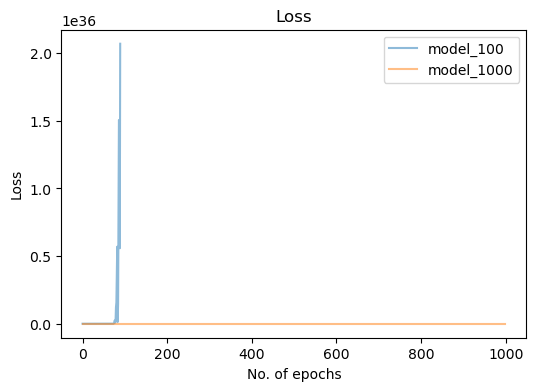

In [44]:
# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(history_100.history['loss'], label='model_100', alpha=.5)
plt.plot(history_1000.history['loss'], label='model_1000', alpha=.5)
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
y_pred_100 = model_100(x_train_100)
y_pred_1000 = model_1000(x_train_1000)

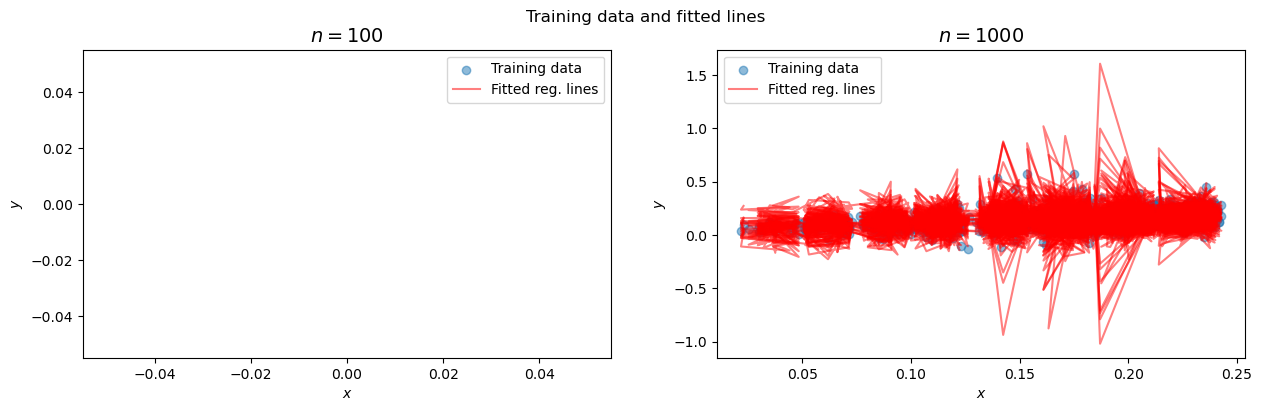

In [46]:
# Plot fitted regression lines
N_ITERS = 15

plt.figure(figsize=(15, 4))

#------------------------------

plt.subplot(121)
plt.scatter(y_train_100, y_pred_100, alpha=.5, marker="o",label='Training data')
for _ in range(N_ITERS):
    y_model_100 = model_100(x_train_100)
    if _ == 0:
        plt.plot(y_train_100, y_model_100, color='red', alpha=0.5, label='Fitted reg. lines')
    else:
        plt.plot(y_train_100, y_model_100, color='red', alpha=0.5)        

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$n=100$', fontsize=14)
plt.legend()

#------------------------------

plt.subplot(122)
plt.scatter(y_train_1000, y_pred_1000, alpha=.5,marker="o" ,label='Training data')
for _ in range(N_ITERS):
    y_model_1000 = model_1000(x_train_1000)
    if _ == 0:
        plt.plot(y_train_1000, y_model_1000, color='red', alpha=0.5, label='Fitted reg. lines')
    else:
        plt.plot(y_train_1000, y_model_1000, color='red', alpha=0.5)        

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$n=1000$', fontsize=14)
plt.legend()

#------------------------------

plt.suptitle('Training data and fitted lines')
plt.show()

## 4. Going fully probabilistic: aleatoric & epistemic uncertainty

In [47]:
callback_earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_onedenselayer.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 4.1 Fully probabilistic non-linear case 

https://keras.io/examples/keras_recipes/bayesian_neural_networks/

In [48]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
# Prior - diagonal MVN ~ N(0, 1)
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential([
        tfpl.DistributionLambda(
            # Non-trianable distribution
            lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    return prior_model

# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
# Posterior
def posterior(kernel_size, bias_size, dtype=None):   
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])   
    return posterior_model

In [49]:
# Define the model
def get_onedenselayer_model(x_train_shape):
    
    model = tf.keras.Sequential([

        # Create hidden layers with weight uncertainty using the DenseVariational layer.
        # Epistemic uncertainty
        tfpl.DenseVariational(units=200,
                              input_shape=(6,),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        #The output is deterministic: a single point estimate.
        tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_use_exact=False,
                              kl_weight=1/x_train_shape),

        # Aleatoric uncertainty
        tfpl.IndependentNormal(1)
    ])

    def neg_loglik(y_true, y_pred):
        return -y_pred.log_prob(y_true)

    model.compile(loss=neg_loglik, optimizer='rmsprop')
    
    return model

In [50]:
# Get the model
n_samples = x_train.shape[0]
model_onedenselayer = get_onedenselayer_model(n_samples)

In [51]:
model_onedenselayer.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_2 (Dense  (None, 200)               982100    
 Variational)                                                    
                                                                 
 dense_variational_3 (Dense  (None, 2)                 81405     
 Variational)                                                    
                                                                 
 independent_normal_1 (Inde  ((None, 1),               0         
 pendentNormal)               (None, 1))                         
                                                                 
Total params: 1063505 (4.06 MB)
Trainable params: 1063505 (4.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
# Early Stopping Callback
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, min_delta=0, mode='auto', baseline=None, restore_best_weights=True)

# save model
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_onedenselayer.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

# tensorboard 
os.makedirs('./run/logs/onedenselayer',   mode=0o750, exist_ok=True)
log_dir = './run/logs/onedenselayer'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq = 1, embeddings_freq=1)

In [53]:
%%time
# Fit
history = model_onedenselayer.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=100, verbose=1, callbacks = [earlystopping_callback] )

Epoch 1/100
593/593 [==============================] - 32s 49ms/step - loss: 11643390532519985152.0000 - val_loss: 298632168467333120.0000
Epoch 2/100
593/593 [==============================] - 29s 49ms/step - loss: nan - val_loss: nan
Epoch 3/100
593/593 [==============================] - 27s 46ms/step - loss: nan - val_loss: nan
Epoch 4/100
593/593 [==============================] - 21s 36ms/step - loss: nan - val_loss: nan
Epoch 5/100
593/593 [==============================] - 21s 36ms/step - loss: nan - val_loss: nan
Epoch 6/100
593/593 [==============================] - 22s 38ms/step - loss: nan - val_loss: nan
Epoch 7/100
593/593 [==============================] - 22s 37ms/step - loss: nan - val_loss: nan
Epoch 8/100
593/593 [==============================] - 21s 35ms/step - loss: nan - val_loss: nan
Epoch 9/100
593/593 [==============================] - 23s 38ms/step - loss: nan - val_loss: nan
Epoch 10/100
593/593 [==============================] - 22s 36ms/step - loss: nan - v

In [54]:
[print(np.squeeze(w.numpy())) for w in model_onedenselayer.weights];

[ 0.00259903 -0.00261181 -0.00644383 ...  0.02022244  0.00993529
 -0.00507444]
[ 0.01200812  0.01381082  0.00726613 ...  0.01019805 -0.00570437
 -0.01093448]


In [55]:
y_pred_train = model_onedenselayer(x_train).sample()

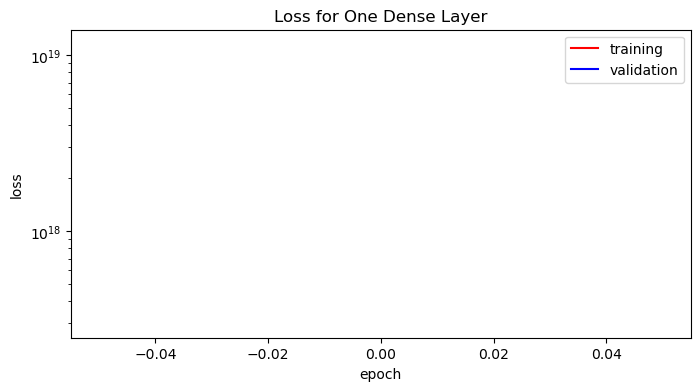

In [56]:
fig = plt.figure(figsize=(8,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Loss for One Dense Layer")
ax.set_yscale('log')

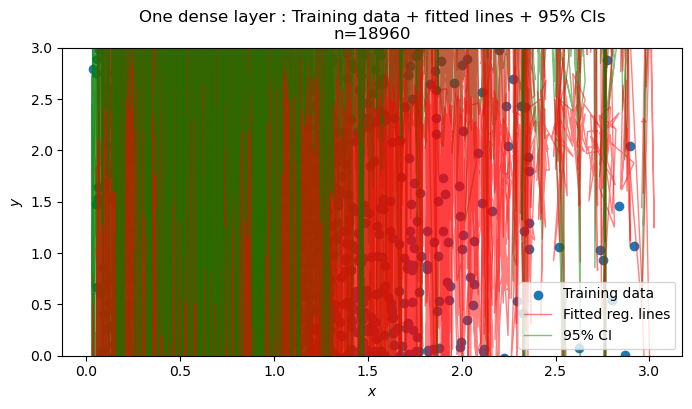

In [57]:
# Plot fitted regression lines
N_ITERS = 15

plt.figure(figsize=(8, 4))

#------------------------------

plt.scatter(y_train, y_pred_train, alpha=1, label='Training data')
for _ in range(N_ITERS):
    
    # Compute conf ints
    y_sample = model_onedenselayer(x_train).sample()
    y_hat = model_onedenselayer(x_train).mean()
    y_sd = model_onedenselayer(x_train).stddev()
    y_hat_lower = y_hat - 2 * y_sd
    y_hat_upper = y_hat + 2 * y_sd
    

    if _ == 0:
        plt.plot(y_train, y_hat, color='red', alpha=.5, lw=1, label='Fitted reg. lines')
        plt.plot(y_train, y_hat_lower, c='g', alpha=.5, lw=1, label='95% CI')
        plt.plot(y_train, y_hat_upper, c='g', alpha=.5, lw=1)
    else:
        plt.plot(y_train, y_hat, color='red', alpha=.5, lw=1)    
        plt.plot(y_train, y_hat_lower, c='g', alpha=.5, lw=1)
        plt.plot(y_train, y_hat_upper, c='g', alpha=.5, lw=1)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.ylim(0,3)
#------------------------------

plt.title(f'One dense layer : Training data + fitted lines + 95% CIs\nn={n_samples}')
plt.show()

## Two dense hidden layers

In [58]:
# Define the model
def get_twodenselayers_model(x_train_shape):
    
    model = tf.keras.Sequential([

        # Epistemic uncertainty
        tfpl.DenseVariational(units=200,
                              input_shape=(6,),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        tfpl.DenseVariational(units=200,
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        
        tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_use_exact=False,
                              kl_weight=1/x_train_shape),

        # Aleatoric uncertainty
        tfpl.IndependentNormal(1)
    ])

    def neg_loglik(y_true, y_pred):
        return -y_pred.log_prob(y_true)

    model.compile(loss=neg_loglik, optimizer='rmsprop')
    
    return model

In [59]:
%%time
n_samples = x_train.shape[0]
# Initialize the model
model_twodenselayers = get_twodenselayers_model(n_samples)

CPU times: user 2.36 s, sys: 3.63 s, total: 5.99 s
Wall time: 2.82 s


In [60]:
model_twodenselayers.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_4 (Dense  (None, 200)               982100    
 Variational)                                                    
                                                                 
 dense_variational_5 (Dense  (None, 200)               808080300 
 Variational)                                                    
                                                                 
 dense_variational_6 (Dense  (None, 2)                 81405     
 Variational)                                                    
                                                                 
 independent_normal_2 (Inde  ((None, 1),               0         
 pendentNormal)               (None, 1))                         
                                                                 
Total params: 809143805 (3.01 GB)
Trainable params: 80

In [61]:
# Early Stopping Callback
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, min_delta=0, mode='auto', baseline=None, restore_best_weights=True)

# Save model
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_twodenselayer.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

# tensorboard callback not working with DenseVariationalLayer
os.makedirs('./run/logs/twodenselayers',   mode=0o750, exist_ok=True)
log_dir = './run/logs/twodenselayers'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq = 1, embeddings_freq=1)


In [ ]:
# Fit
history = model_twodenselayers.fit(x_train, y_train, validation_data = (x_test, y_test),epochs=200, verbose=1,callbacks=[earlystopping_callback  ])

Epoch 1/200
 19/593 [..............................] - ETA: 24:51:50 - loss: 32924258795520.0000

In [ ]:
[print(np.squeeze(w.numpy())) for w in model_twodenselayers.weights];

In [ ]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Loss for Two Dense Layers")
ax.set_yscale('log')

In [ ]:
y_pred_train = model_twodenselayers(x_train).sample()
y_pred_test = model_twodenselayers(x_test).sample()

In [ ]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r',label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b',label='Test data')
ax.set_title("Loss for Two Dense Layers")
ax.set_ylim(0,3)

In [ ]:
# Plot fitted regression lines
N_ITERS = 15

plt.figure(figsize=(9, 6))

#------------------------------

plt.scatter(y_train, y_pred_train, alpha=.1, label='Training data')
for _ in range(N_ITERS):
    
    # Compute conf ints
    y_sample = model_twodenselayers(x_train).sample()
    y_hat = model_twodenselayers(x_train).mean()
    y_sd = model_twodenselayers(x_train).stddev()
    y_hat_lower = y_hat - 2 * y_sd
    y_hat_upper = y_hat + 2 * y_sd
    

    if _ == 0:
        plt.plot(y_train, y_hat, color='red', alpha=.5, lw=1, label='Fitted reg. lines')
        plt.plot(y_train, y_hat_lower, c='g', alpha=.5, lw=1, label='95% CI')
        plt.plot(y_train, y_hat_upper, c='g', alpha=.5, lw=1)
    else:
        plt.plot(y_train, y_hat, color='red', alpha=.5, lw=1)    
        plt.plot(y_train, y_hat_lower, c='g', alpha=.5, lw=1)
        plt.plot(y_train, y_hat_upper, c='g', alpha=.5, lw=1)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.ylim(0,3)
#------------------------------

plt.title(f'Two dense layers : Training data + fitted lines + 95% CIs\nn={n_samples}')
plt.show()

## 3 layers

In [ ]:
# Define the model
def get_3hiddenlayers_model(x_train_shape):
    
    model = tf.keras.Sequential([

        # Epistemic uncertainty
        tfpl.DenseVariational(units=200,
                              input_shape=(6,),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        tfpl.DenseVariational(units=200,
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        
        tfpl.DenseVariational(units=200,
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        
        tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_use_exact=False,
                              kl_weight=1/x_train_shape),

        # Aleatoric uncertainty
        tfpl.IndependentNormal(1)
    ])

    def neg_loglik(y_true, y_pred):
        return -y_pred.log_prob(y_true)

    model.compile(loss=neg_loglik, optimizer='rmsprop')
    
    return model

In [ ]:
%%time
n_samples = x_train.shape[0]
# Initialize the model
model_3hiddenlayers = get_3hiddenlayers_model(n_samples)

In [ ]:
model_3hiddenlayers.summary()

In [ ]:
# Early Stopping Callback
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, min_delta=0, mode='auto', baseline=None, restore_best_weights=True)

# Save model
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_threedenselayers.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

# tensorboard callback not working with DenseVariationalLayer
os.makedirs('./run/logs/threedenselayers',   mode=0o750, exist_ok=True)
log_dir = './run/logs/threedenselayers'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq = 1, embeddings_freq=1)

In [ ]:
# Fit
history = model_3hiddenlayers.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=200, verbose=1,callbacks=[ earlystopping_callback])

In [ ]:
[print(np.squeeze(w.numpy())) for w in model_3hiddenlayers.weights];

In [ ]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Loss for Three Dense Layers")
ax.set_yscale('log')

In [ ]:
y_pred_train = model_3hiddenlayers(x_train).sample()
y_pred_test = model_3hiddenlayers(x_test).sample()

In [ ]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', label='test data')
ax.set_title("Loss for Three Dense Layers")
ax.set_ylim(0,3)

## Four layers

In [ ]:
# Define the model
def get_4hiddenlayers_model(x_train_shape):
    
    model = tf.keras.Sequential([

        # Epistemic uncertainty
        tfpl.DenseVariational(units=32,
                              input_shape=(6,),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        tfpl.DenseVariational(units=64,
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        
        tfpl.DenseVariational(units=64,
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        
        
        tfpl.DenseVariational(units=32,
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='sigmoid'),
        
        tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_use_exact=False,
                              kl_weight=1/x_train_shape),

        # Aleatoric uncertainty
        tfpl.IndependentNormal(1)
    ])

    def neg_loglik(y_true, y_pred):
        return -y_pred.log_prob(y_true)

    model.compile(loss=neg_loglik, optimizer='rmsprop')
    
    return model

In [ ]:
%%time
n_samples = x_train.shape[0]
# Initialize the model
model_4hiddenlayers = get_4hiddenlayers_model(n_samples)

In [ ]:
model_4hiddenlayers.summary()

In [ ]:
# Fit
history = model_4hiddenlayers.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=200, verbose=1,callbacks=[ earlystopping_callback])

In [ ]:
[print(np.squeeze(w.numpy())) for w in model_4hiddenlayers.weights];

In [ ]:
fig = plt.figure(figsize=(5,4))
ax  = fig.add_subplot(1,1,1)
ax.plot(history.history['loss'],'r-',label="training")
ax.plot(history.history['val_loss'],'b-',label="validation")
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Loss for Four Dense Layers")
ax.set_yscale('log')

In [ ]:
y_pred_train = model_4hiddenlayers(x_train).sample()
y_pred_test = model_4hiddenlayers(x_test).sample()

In [ ]:
fig = plt.figure(figsize=(6, 6))
#------------------------------
ax = fig.add_subplot(1,1,1)
ax.scatter(y_train, y_pred_train, alpha=.1, c='r', label='Training data')
ax.scatter(y_test, y_pred_test, alpha=.1, c='b', label='Test data')
ax.set_title("Loss for Four Dense Layers")
ax.set_ylim(0,3)